In [1]:
import os
import numpy as np
import h5py as h5

import fnmatch
import matplotlib.pyplot as plt
from torch3dseg.datasets.utils import SliceBuilder
import configparser

In [7]:
src_path = "/Volumes/data/scratch"
dest_path = "/Volumes/LaCie/scratch"

In [8]:
found_first_item = False
num_subvolumes = 2

for root, dirs, files in os.walk(src_path):

    # Copy all raw files to the destination path
    for file in fnmatch.filter(files,"*.raw"):
          # Add more file extensions if needed
        src_file_path = os.path.join(root, file)

        # Create corresponding subdirectories in the destination path
        relative_path = os.path.relpath(root, src_path)
        destination_dir = os.path.join(dest_path, relative_path)

    
    
        os.makedirs(destination_dir, exist_ok=True)
        destination_dir_sub = os.path.join(dest_path, relative_path,"rand_subvolume")
        os.makedirs(destination_dir_sub, exist_ok=True)

        dest_file_path = os.path.join(destination_dir, os.path.splitext(file)[0]+".h5")

        config = configparser.ConfigParser()
        # Read the text file
        config.read(os.path.join(root,os.path.splitext(file)[0]+".volumeinfo"))
        print(os.path.join(src_file_path,os.path.splitext(file)[0]+".volumeinfo"))

        print(config.sections())
        
        # Extract data from the [Volume] section
        volume_data = {
            'SizeX': config.getint('Volume', 'SizeX'),
            'SizeY': config.getint('Volume', 'SizeY'),
            'SizeZ': config.getint('Volume', 'SizeZ'),
            'Origin': (0,0,0),
            'VoxelSizeX': config.getfloat('Volume', 'VoxelSizeX'),
            'VoxelSizeY': config.getfloat('Volume', 'VoxelSizeY'),
            'VoxelSizeZ': config.getfloat('Volume', 'VoxelSizeZ'),
            'Datatype': config.get('Volume', 'Datatype'),
            'UsedBits': config.getint('Volume', 'UsedBits'),
            'Offset': config.getfloat('Volume', 'Offset'),
            'Scale': config.getfloat('Volume', 'Scale'),
            'Min': config.getint('Volume', 'Min'),
            'Max': config.getint('Volume', 'Max'),
            'HistogramUpToDate': config.getboolean('Volume', 'HistogramUpToDate')
            }

        # load raw
        shape = (volume_data["SizeZ"],volume_data["SizeY"],volume_data["SizeX"])
            # Map the Datatype string to NumPy data type
        datatype_mapping = {
            'uint8': np.uint8,
            'uint16': np.uint16,
            'uint32': np.uint32,
            'uint64': np.uint64,
            'int8': np.int8,
            'int16': np.int16,
            'int32': np.int32,
            'int64': np.int64,
            'float16': np.float16,
            'float32': np.float32,
            'float64': np.float64,
        }

        dtype  = datatype_mapping.get(volume_data['Datatype'], np.uint16)

        print(shape,dtype)
        # Read the binary data from the file into a NumPy array
        try:
            with open(src_file_path, 'rb') as f:
                raw_data = np.fromfile(f, dtype=dtype)
                # If you have a specific shape, reshape the array accordingly
                if shape:
                    raw_data = raw_data.reshape(shape)
        except FileNotFoundError:
            print(f"File  '{src_file_path}' not found.")
            raw_data = None
    
        ##-----------------------------------
        ## Export as h5
        ##-----------------------------------

        out = {}
        out['raw'] = raw_data
        out['volume_data'] = volume_data

    
        with h5.File(dest_file_path, 'w',) as fout:
            for key in out.keys():
                if key == "volume_data":
                    volume_group = fout.create_group('volume_data')
                    for key, value in volume_data.items():
                        volume_group.create_dataset(key, data=value)
                else:
                    fout.create_dataset(key, data = out[key],compression="gzip")
        
        ##-----------------------------------
        ## Extract Subvolumes
        ##-----------------------------------

        builder = SliceBuilder(
            raw_dataset=raw_data,
            label_dataset=None,
            weight_dataset=None,
            patch_shape=[shape[0] , 256, 256],
            stride_shape=[shape[0] , 64, 64])

        slices = builder.raw_slices
        for n in range(num_subvolumes):
            rand_idx = np.random.randint(len(slices))
            print(rand_idx)
            slice = slices[rand_idx]
            
            x,y,z = slice


            volume_data["Origin"] = (x.start, y.start, z.start)

            sub_out = {}
            sub_out['raw'] = raw_data[slice]
            sub_out['volume_data'] = volume_data

            dest_file_path_sub = os.path.join(destination_dir_sub, os.path.splitext(file)[0]+"_%s"%n+".h5")
            print(dest_file_path_sub)
            with h5.File(dest_file_path_sub, 'w',) as fout:
                for key in out.keys():
                    if key == "volume_data":
                        volume_group = fout.create_group('volume_data')
                        for key, value in sub_out['volume_data'].items():
                            volume_group.create_dataset(key, data=value)
                    else:
                        fout.create_dataset(key, data = sub_out[key],compression="gzip")

        print(f"Converted: {src_file_path} to {dest_file_path}")
        ## For testing
        found_first_item = False
        break

    if found_first_item:
        break



/Volumes/data/scratch/285_05-layer/volumes/00/285_05-layer_00.raw/285_05-layer_00.volumeinfo
['Volume', 'VolumeHistogram']
(500, 2200, 2200) <class 'numpy.uint16'>
424
/Volumes/LaCie/scratch/285_05-layer/volumes/00/rand_subvolume/285_05-layer_00_0.h5
217
/Volumes/LaCie/scratch/285_05-layer/volumes/00/rand_subvolume/285_05-layer_00_1.h5
Converted: /Volumes/data/scratch/285_05-layer/volumes/00/285_05-layer_00.raw to /Volumes/LaCie/scratch/285_05-layer/volumes/00/285_05-layer_00.h5
/Volumes/data/scratch/285_05-layer/volumes/01/285_05-layer_01.raw/285_05-layer_01.volumeinfo
['Volume', 'VolumeHistogram']
(500, 2200, 2200) <class 'numpy.uint16'>
486
/Volumes/LaCie/scratch/285_05-layer/volumes/01/rand_subvolume/285_05-layer_01_0.h5
325
/Volumes/LaCie/scratch/285_05-layer/volumes/01/rand_subvolume/285_05-layer_01_1.h5
Converted: /Volumes/data/scratch/285_05-layer/volumes/01/285_05-layer_01.raw to /Volumes/LaCie/scratch/285_05-layer/volumes/01/285_05-layer_01.h5
/Volumes/data/scratch/285_05-lay

In [4]:
def readH5(file_path,**kwargs):
    """
    generic function to read a h5 file with one 
    subgroup elements by given filepath in a Dictonary 
    """

    import h5py as h5
    
    out = {}

    with h5.File(file_path, 'r') as f:

        for key in f.keys():

            if isinstance(f[key],h5.Group):
                out[key] = {}
                for sub_key in f[key]:
                    out[key][sub_key] = f[key][sub_key][...]
            else:
                out[key] = f[key][:]
        f.close()
    return out

In [6]:
print(dest_file_path_sub)
print(dest_file_path)



vol1 = readH5(dest_file_path_sub)
vol2 = readH5(dest_file_path)

/Volumes/LaCie 1/scratch/160_01-layer/volumes/00/rand_subvolume/160_01-layer_00_1.h5
/Volumes/LaCie 1/scratch/160_01-layer/volumes/00/160_01-layer_00.h5
raw
volume_data


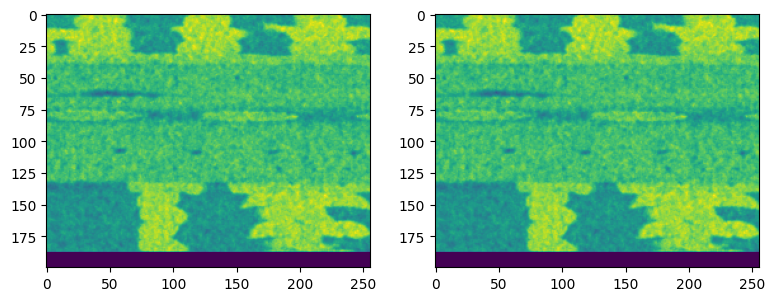

In [9]:

z,y,x = vol1["volume_data"]["Origin"]

fig, axs = plt.subplots(1,2,figsize=(2*4.6,4.6))

axs = axs.flatten()

axs[0].imshow(vol1["raw"][:,0,:])

axs[1].imshow(vol2["raw"][:,y,x:x+256])

In [6]:
found_first_item = False
for root, dirs, files in os.walk(path, topdown=False):
   
   for fname in fnmatch.filter(files,"*.raw"):
      
      print(root)
      print(fname)
      
      ## For testing
      found_first_item = True
      break

   if found_first_item:
      break

/Volumes/data/160_01-layer/volumes/00
160_01-layer_00.raw


In [22]:
found_first_item = False

for root, dirs, files in os.walk(path, topdown=False):
   
   for fname in fnmatch.filter(files,"*.raw")[:1]:
        print(os.path.join(root, fname))

        config = configparser.ConfigParser()
        # Read the text file
        config.read(os.path.join(root,os.path.splitext(fname)[0]+".volumeinfo"))
        
        print(config.sections())
        
        # Extract data from the [Volume] section
        volume_data = {
            'SizeX': config.getint('Volume', 'SizeX'),
            'SizeY': config.getint('Volume', 'SizeY'),
            'SizeZ': config.getint('Volume', 'SizeZ'),
            'Origin': (0,0,0),
            'VoxelSizeX': config.getfloat('Volume', 'VoxelSizeX'),
            'VoxelSizeY': config.getfloat('Volume', 'VoxelSizeY'),
            'VoxelSizeZ': config.getfloat('Volume', 'VoxelSizeZ'),
            'Datatype': config.get('Volume', 'Datatype'),
            'UsedBits': config.getint('Volume', 'UsedBits'),
            'Offset': config.getfloat('Volume', 'Offset'),
            'Scale': config.getfloat('Volume', 'Scale'),
            'Min': config.getint('Volume', 'Min'),
            'Max': config.getint('Volume', 'Max'),
            'HistogramUpToDate': config.getboolean('Volume', 'HistogramUpToDate')
            }
        # Extract data from the [VolumeHistogram] section   
        volume_histogram_data = {
            'BucketCount': config.getint('VolumeHistogram', 'BucketCount')
        }
        # Create a NumPy array for the histogram data
        bucket_count = volume_histogram_data['BucketCount']
        volume_histogram_array = np.zeros(bucket_count, dtype=int)
        for i in range(bucket_count):
            bucket_key = f'Bucket{i}'
            volume_histogram_array[i] = config.getint('VolumeHistogram', bucket_key)

        # load raw
        shape = (volume_data["SizeZ"],volume_data["SizeY"],volume_data["SizeX"])
            # Map the Datatype string to NumPy data type
        datatype_mapping = {
            'uint8': np.uint8,
            'uint16': np.uint16,
            'uint32': np.uint32,
            'uint64': np.uint64,
            'int8': np.int8,
            'int16': np.int16,
            'int32': np.int32,
            'int64': np.int64,
            'float16': np.float16,
            'float32': np.float32,
            'float64': np.float64,
        }

        dtype  = datatype_mapping.get(volume_data['Datatype'], np.uint16)

        print(shape,dtype)
        # Read the binary data from the file into a NumPy array
        try:
            with open(os.path.join(root, fname), 'rb') as file:
                raw_data = np.fromfile(file, dtype=dtype)
                # If you have a specific shape, reshape the array accordingly
                if shape:
                    raw_data = raw_data.reshape(shape)
        except FileNotFoundError:
            print(f"File '{file_path}' not found.")
            raw_data = None

        if raw_data is not None:
            # Now you have your data in a NumPy array (raw_data)
            print(raw_data.shape,raw_data.dtype,raw_data.nbytes/1024**2)

        out = {}
        out['raw'] = raw_data
        # print(volume_data.dtype)
        out['volume_data'] = volume_data
        # out['volume_histogram_data'] = volume_histogram_array

            


        fout = os.path.join(root,os.path.splitext(fname)[0]+".h5")
        with h5.File(fout, 'w',) as fout:
            for key in out.keys():
                if key == "volume_data":
                    volume_group = fout.create_group('volume_data')
                    for key, value in volume_data.items():
                        volume_group.create_dataset(key, data=value)
                else:
                    fout.create_dataset(key, data = out[key])


        ## For testing
        found_first_item = True
        break

   if found_first_item:
        break

/Volumes/data/160_01-layer/volumes/00/160_01-layer_00.raw
['Volume', 'VolumeHistogram']
(200, 2200, 2200) <class 'numpy.uint16'>
(200, 2200, 2200) uint16 1846.3134765625


In [6]:
file_path = "/Volumes/data/160_01-layer/volumes/00/160_01-layer_00.raw"# Define the file path and data type

dtype = np.uint16  # Change this to the appropriate data type (e.g., np.uint8, np.int16, etc.)
shape = (200,2200,2200)  # Define the shape of the array (e.g., (height, width))

In [7]:
# Read the binary data from the file into a NumPy array
try:
    with open(file_path, 'rb') as file:
        raw_data = np.fromfile(file, dtype=dtype)
        # If you have a specific shape, reshape the array accordingly
        if shape:
            raw_data = raw_data.reshape(shape)
except FileNotFoundError:
    print(f"File '{file_path}' not found.")
    raw_data = None

if raw_data is not None:
    # Now you have your data in a NumPy array (raw_data)
    print(raw_data.shape,raw_data.dtype,raw_data.nbytes/1024**2)

(200, 2200, 2200) uint16 1846.3134765625


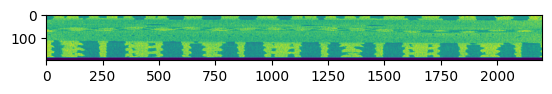

In [11]:
plt.imshow(raw_data[:,50,:])

In [13]:
with h5.File('data.h5', 'w') as h5file:
    h5file.create_dataset('raw', data=raw_data)


In [19]:
%%timeit -r 1 -n 5
data = {}

with h5.File("data.h5", 'r') as hdf5_file:
    file = hdf5_file
    for key in hdf5_file.keys():
        data[key] = hdf5_file[key][:]
print(data.keys())

dict_keys(['raw'])
dict_keys(['raw'])
dict_keys(['raw'])
dict_keys(['raw'])
dict_keys(['raw'])
314 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 5 loops each)


In [20]:
%%timeit -r 1 -n 5
data = {}








with h5.File("data_gzip.h5", 'r') as hdf5_file:
    file = hdf5_file
    for key in hdf5_file.keys():
        data[key] = hdf5_file[key][:]
print(data.keys())

dict_keys(['raw'])
dict_keys(['raw'])
dict_keys(['raw'])
dict_keys(['raw'])
dict_keys(['raw'])
16.8 s ± 0 ns per loop (mean ± std. dev. of 1 run, 5 loops each)
